# Modelling Exploration Notebook V1

This Notebook focuses on comparing different forecast models provided by GluonTS. <br /> 
Experiments were run using Python 3.9 and PyTorch 1.13. <br /> 
Compared were:
- DeepAR (Salinas et al. 2020): [torch impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py)
- DeepState (Rangapuram et al. 2018): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py)
- MQ-CNN (Wen et al. 2017): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py)

In [4]:
# Required Packages
# !pip install -r ./src/requirements.txt

In [3]:
# Imports experiment script
from src.forecast_experiment import run_experiment
from src.forecast_util import plot_forecast
# Import packages
from datetime import timedelta
import json

/opt/conda/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Experiment Overview

### Define Configuration Store

In [41]:
from sqlalchemy import create_engine, Column, Integer, Float, String, PickleType,  select
# from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [42]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    version = Column('version', Integer)
    data_config = Column('data_config', PickleType)
    model_config = Column('model_config', PickleType)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_10', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

In [43]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///./config/forecast_config_v2.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Explore Experiments

The model name follows this naming convention: {framework}_{model_name}. <br />
- The framework specifies the Machine Learning Framework used to implement the model (mxnet, torch, tensorflow)
- The model_name specifies the Algorithm used (e.g. DeepAR). 

The version field is used to track the stage of experiments as defined below. This means general progression of modelling insights as well as updated data sources.

- version 1: first exploration
    - "../data_engineering/financial_ts/indices.csv",
    - "../data_engineering/financial_ts/ww_gdp.csv",
    - "../data_engineering/timeseries_data/ts_dgelt_events.csv"
- version 2: specific exploration
    - "../data_engineering/financial_ts/indices.csv",
    - "../data_engineering/financial_ts/ww_gdp.csv",
    - "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv"

In [38]:
# Query experiment Table and print results:
q1 = select(Forecast_Experiment)
q1_result = session.execute(q1) 

for s in q1_result.scalars():
    print(f"""{s.model} 
        - model_config: {str(s.model_config)[1:-1].replace("'","")}:
        - MAPE: {s.MAPE},
        - avg_wQL: {s.avg_wQL},
        """
    )

NameError: name 'select' is not defined

### Migrate Experiments

The Experiments from the modelling_experimentation_v1 notebook were stored in two different Tables. <br />
I exported them to a json file and used the below code to read the file and store previous experiments in the new database with dynamic config attributes.

In [30]:
import json
 
# Opening JSON file
with open('data_v2.json') as json_file:
    data = json.load(json_file)

In [36]:
for e in data:
    experiment_config = Forecast_Experiment(
        model = e['name'],
        version = 1,
        data_config = {
            'target':e['target'],
            'past_rts_col':e['past_rts_col'],
            'windows':1,
        },
        model_config = {
            'epochs':e['epochs'],
            'prediction_length':e['prediction_length'],
            'num_layers':e['num_layers'],
            'hidden_size':e['hidden_size'],
            # 'context_length':e['context_length'],
            'lr':e['lr'],
            'weight_decay':e['weight_decay'],
        },
        MASE = e['MASE'],
        MAPE = e['MAPE'],
        RMSE = e['RMSE'],
        wQL_10 = e['wQL_10'],
        wQL_50 = e['wQL_50'],
        wQL_90 = e['wQL_90'],
        avg_wQL = e['avg_wQL']
    )
    session.add(experiment_config)
    session.commit()

## DeepAR ([torch](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py))

DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an autoregressive recurrent neural network model on a large number of related time series.

In [5]:
from gluonts.torch import DeepAREstimator

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv"
]
target_col = 'ts_MSCI_World' # switch to ts_S&P
with open('./config/past_rts_cols_v2.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_2']
windows = 3

# Estimator specs
version = 2
prediction_length=56
max_epochs = 5
num_layers=4
hidden_size=60
context_length = 10 
weight_decay = 1e-4
lr = 1e-1

# Trainer specs
accelerator = "cpu"
devices = 1

In [36]:
# Define estimator
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    num_layers=num_layers,  
    hidden_size=hidden_size, 
    weight_decay=weight_decay,
    context_length=context_length,
    lr = lr,
    freq="W",
    trainer_kwargs={
        "max_epochs": max_epochs, 
        "accelerator":accelerator, 
        "devices":devices,
    }
)

In [37]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=deepar_estimator,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 108 K  | ?        | [1, 100, 56]
----------------------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.435     Total estimated model params size (MB)


Epoch 0: : 0it [24:35, ?it/s]
Epoch 0: : 50it [00:12,  3.86it/s, v_num=68, train_loss=0.952]

Epoch 0, global step 50: 'train_loss' reached 0.95199 (best 0.95199), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_68/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:13,  3.73it/s, v_num=68, train_loss=0.838]

Epoch 1, global step 100: 'train_loss' reached 0.83837 (best 0.83837), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_68/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:13,  3.82it/s, v_num=68, train_loss=0.979]

Epoch 2, global step 150: 'train_loss' was not in top 1


Epoch 3: : 50it [00:12,  3.86it/s, v_num=68, train_loss=0.857]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: : 50it [00:12,  4.02it/s, v_num=68, train_loss=0.855]

Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 50it [00:12,  4.01it/s, v_num=68, train_loss=0.855]


Running evaluation: 1it [00:00, 11.50it/s]


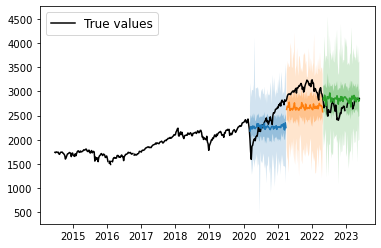

In [39]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./plot.svg",
)

In [44]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'torch_deepar',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'context_length':context_length,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

## DeepState ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py))

DeepState is a novel approach to probabilistic time series forecasting that combines state space models with deep learning. By parametrizing a per-time-series linear state space model with a jointly-learned recurrent neural network, our method retains desired properties of state space models such as data efficiency and interpretability, while making use of the ability to learn complex patterns from raw data offered by deep learning approaches.

In [9]:
from gluonts.mx import DeepStateEstimator
from gluonts.mx import Trainer

In [10]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
num_layers=2
hidden_size=20

# Trainer specs
max_epochs = 100
lr = 1e-1
weight_decay = 1e-4

In [11]:
# Define estimator
deepstate_estimator = DeepStateEstimator(
    prediction_length=prediction_length,
    num_layers=num_layers, 
    num_cells=hidden_size, 
    use_feat_static_cat=False,
    cardinality=[],
    trainer = Trainer(
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    freq="W",
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=deepstate_estimator,
)

100%|██████████| 50/50 [01:33<00:00,  1.87s/it, epoch=100/100, avg_epoch_loss=4.13]
Running evaluation: 1it [00:00,  3.58it/s]


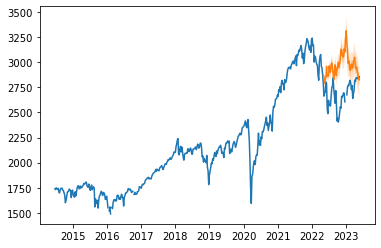

In [13]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./plot.svg",
)

In [14]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_deepstate',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 

## MQ-CNN ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py))

MQ-CNN is a general probabilistic multi-step time series regression model. It exploits the expressiveness and temporal nature of Sequence-to-Sequence Neural Networks (e.g. recurrent and convolutional structures), the nonparametric nature of Quantile Regression and the efficiency of Direct Multi-Horizon Forecasting.


In [6]:
from gluonts.mx import MQCNNEstimator
from gluonts.mx import Trainer
import mxnet as mx

In [7]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
decoder_mlp_dim_seq=[30]
channels_seq=[30,30,30]
use_past_feat_dynamic_real=True
context_length=50

# Trainer specs
max_epochs = 200
lr = 1e-1
weight_decay = 1e-4
ctx = mx.cpu() # mx.gpu()

In [8]:
mqcnn_estimator = MQCNNEstimator(
    prediction_length=prediction_length,
    channels_seq=channels_seq,  
    use_past_feat_dynamic_real=use_past_feat_dynamic_real,
    decoder_mlp_dim_seq=decoder_mlp_dim_seq, 
    context_length=context_length,
    freq="W",
    trainer=Trainer(
        ctx=ctx,
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=mqcnn_estimator,
)

100%|██████████| 50/50 [00:29<00:00,  1.70it/s, epoch=200/200, avg_epoch_loss=1.35]
Running evaluation: 1it [00:00,  6.59it/s]


In [4]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./plot.svg",
)

NameError: name 'tss' is not defined

In [ ]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_cnnqr',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'channels_seq':channels_seq,
        'decoder_mlp_dim_seq':decoder_mlp_dim_seq,
        'use_past_feat_dynamic_real':use_past_feat_dynamic_real,
        'context_length':context_length,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 
print("done")